**Libraries**

In [15]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from datetime import date, timedelta
from statsmodels.tsa.arima_model import ARIMA
from sklearn.cluster import KMeans
from fbprophet import Prophet

**Reading File**

In [16]:
data1=pd.read_csv("data/covid_19_clean_complete.csv")

**Looking into Data**

In [17]:
data1.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,1/22/20,2,0,0
1,NaN,Japan,36.0000,138.0000,1/22/20,2,0,0
2,NaN,Singapore,1.2833,103.8333,1/22/20,0,0,0
3,NaN,Nepal,28.1667,84.2500,1/22/20,0,0,0
4,NaN,Malaysia,2.5000,112.5000,1/22/20,0,0,0


In [18]:
NL = data1.loc[data1['Country/Region']=='Netherlands']

In [19]:
data1.isna().sum()

Province/State    5300
Country/Region       0
Lat                  0
Long                 0
Date                 0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [20]:
daily = data1.sort_values(['Date','Country/Region','Province/State'])
latest = data1[data1.Date == daily.Date.max()]
latest.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
18988,NaN,Thailand,15.0000,101.0000,3/9/20,50,1,31
18989,NaN,Japan,36.0000,138.0000,3/9/20,511,10,76
18990,NaN,Singapore,1.2833,103.8333,3/9/20,150,0,78
18991,NaN,Nepal,28.1667,84.2500,3/9/20,1,0,1
18992,NaN,Malaysia,2.5000,112.5000,3/9/20,117,0,24


In [21]:
data=latest.rename(columns={ "Country/Region": "country", "Province/State": "state","Confirmed":"confirm","Deaths": "death","Recovered":"recover"})
data.head()


,state,country,Lat,Long,Date,confirm,death,recover
18988,NaN,Thailand,15.0000,101.0000,3/9/20,50,1,31
18989,NaN,Japan,36.0000,138.0000,3/9/20,511,10,76
18990,NaN,Singapore,1.2833,103.8333,3/9/20,150,0,78
18991,NaN,Nepal,28.1667,84.2500,3/9/20,1,0,1
18992,NaN,Malaysia,2.5000,112.5000,3/9/20,117,0,24


In [77]:
float(data.loc[data.country == 'Netherlands','Long'])

5.2913

In [88]:
dgc=data.groupby("country")[['confirm', 'death', 'recover']].sum().reset_index()
dgc['long'] = dgc.country.apply(lambda x: float(data.loc[data.country == x,'Long'].mean()))
dgc['lat'] = dgc.country.apply(lambda x: float(data.loc[data.country == x,'Lat'].mean()))
dgc['Active'] = dgc.confirm - dgc.death - dgc.recover
dgc.head()

,country,confirm,death,recover,long,lat,Active
0,Afghanistan,4,0,0,65.0000,33.0000,4
1,Albania,2,0,0,20.1683,41.1533,2
2,Algeria,20,0,0,1.6596,28.0339,20
3,Andorra,1,0,0,1.5218,42.5063,1
4,Argentina,12,1,0,-63.6167,-38.4161,11


In [89]:
dgc = dgc.loc[dgc.confirm>0]

**Grphing into World Map**

In [101]:
 import folium
worldmap = folium.Map(location=[32.4279,53.6880 ], zoom_start=4,tiles='Stamen Terrain')
for country, Lat, Long, active, confirm, death, recover in zip(dgc.country, dgc['lat'], dgc['long'], dgc['Active'], dgc['confirm'], dgc['death'], dgc['recover']):
    if active > 5000:
        color = 'red'
    elif active > 1000:
        color = 'Orange'
    else:
        color = 'Yellow'
    folium.CircleMarker([Lat, Long],
                        radius=active/200,
                        color=color,
                      popup =(country+'<br> Active: ' + str(active) + '<br> Confirmed: ' + str(confirm) + '<br> Death: '+ str(death) + '<br> Recovered: '+ str(recover) + '<br>'),
                        fill_color=color,
                        fill_opacity=0.7 ).add_to(worldmap)
worldmap

In [108]:
fig = px.bar(dgc[['country', 'confirm']].sort_values('confirm', ascending=False), 
             y="confirm", x="country", color='country', 
             log_y=True, template='ggplot2', title='Active Cases')
fig.show()

In [105]:
fig = px.bar(dgc[['country', 'Active']].sort_values('Active', ascending=False), 
             y="Active", x="country", color='country', 
             log_y=True, template='ggplot2', title='Active Cases')
fig.show()

In [106]:
fig = px.bar(dgc[['country', 'recover']].sort_values('recover', ascending=False), 
             y="recover", x="country", color='country', 
             log_y=True, template='ggplot2', title='Recovered Cases')
fig.show()

In [107]:
fig = px.bar(dgc[['country', 'death']].sort_values('death', ascending=False), 
             y="death", x="country", color='country', 
             log_y=True, template='ggplot2', title='Death')
fig.show()


In [109]:
data1.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,1/22/20,2,0,0
1,NaN,Japan,36.0000,138.0000,1/22/20,2,0,0
2,NaN,Singapore,1.2833,103.8333,1/22/20,0,0,0
3,NaN,Nepal,28.1667,84.2500,1/22/20,0,0,0
4,NaN,Malaysia,2.5000,112.5000,1/22/20,0,0,0


**For Iran**

In [113]:
nl_data = data1[data1['Country/Region']=='Netherlands']
nl_data = nl_data[nl_data.Confirmed > 0]

**Confirmation vs Recoverey vs Death**

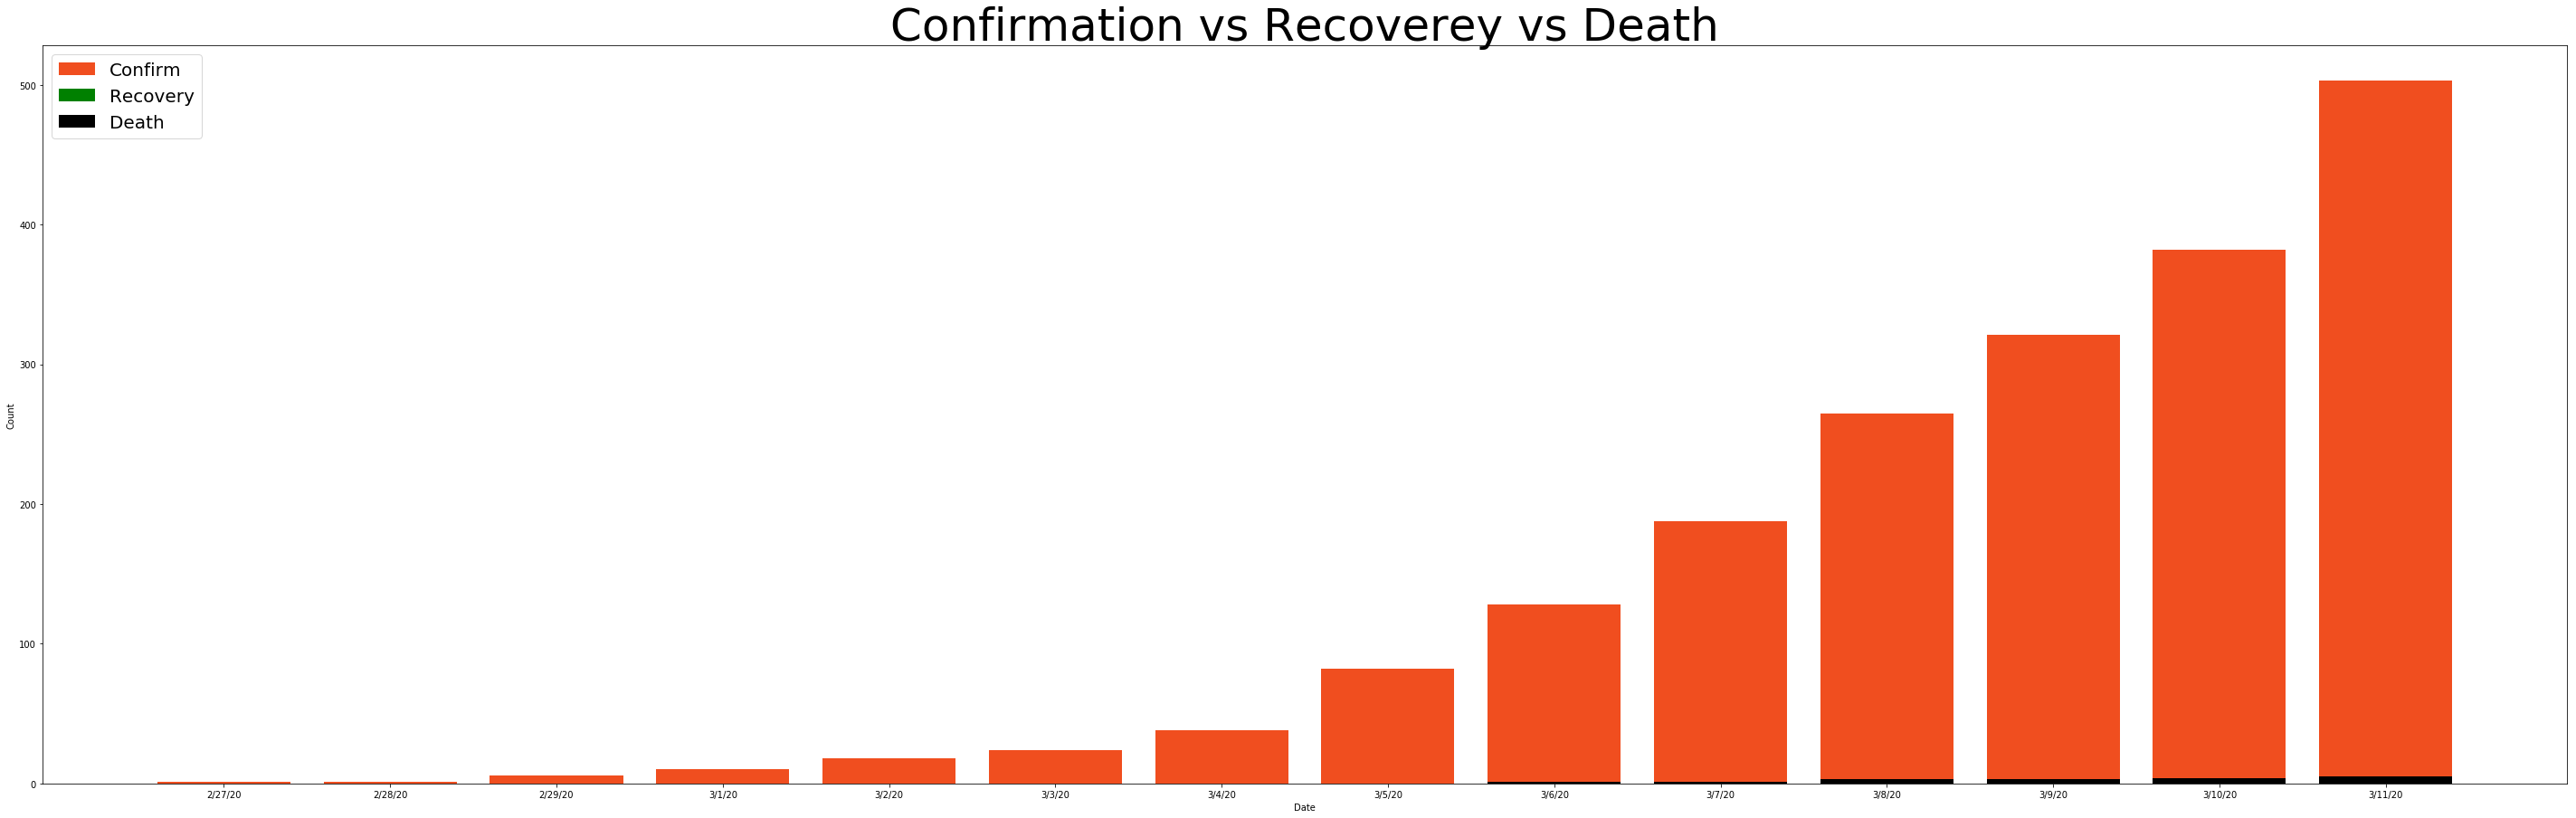

In [123]:
plt.figure(figsize=(50,15))
plt.bar(nl_data.Date, nl_data.Confirmed, color="#f04e1f", label="Confirm")
plt.bar(nl_data.Date, nl_data.Recovered,color="green", label="Recovery")
plt.bar(nl_data.Date, nl_data.Deaths,color="black", label="Death")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=20)
plt.title("Confirmation vs Recoverey vs Death",fontsize=50)
plt.show()

**Grouping By Date**

In [129]:
dgd=data.groupby("Date")[['confirm', 'death', 'recover']].sum().reset_index()

**Ratio and Percentage of Recovery and Death after Confirmation**

In [130]:
r_cm = float(dgd.recover/dgd.confirm)
d_cm = float(dgd.death/dgd.confirm)

In [131]:
print("The percentage of recovery after confirmation is "+ str(r_cm*100) )
print("The percentage of death after confirmation is "+ str(d_cm*100) )


The percentage of recovery after confirmation is 55.031216702917376
The percentage of death after confirmation is 3.5117690052042514


 > **For Confirmed Cases**

**Prophet**

In [132]:
prophet=nl_data.iloc[: , [4,5]].copy() 
prophet.head()
prophet.columns = ['ds','y']
prophet.head()

,ds,y
14586,2/27/20,1
14990,2/28/20,1
15394,2/29/20,6
15798,3/1/20,10
16202,3/2/20,18


In [133]:
m=Prophet()
m.fit(prophet)
future=m.make_future_dataframe(periods=365)
forecast=m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-27,-95.692443,-180.238103,-13.712900,-95.692443,-95.692443,0.0,0.0,0.0,0.0,0.0,0.0,-95.692443
1,2020-02-28,-59.357198,-139.352522,16.056328,-59.357198,-59.357198,0.0,0.0,0.0,0.0,0.0,0.0,-59.357198
2,2020-02-29,-23.021953,-102.007163,58.241839,-23.021953,-23.021953,0.0,0.0,0.0,0.0,0.0,0.0,-23.021953
3,2020-03-01,13.313291,-63.085831,89.609171,13.313291,13.313291,0.0,0.0,0.0,0.0,0.0,0.0,13.313291
4,2020-03-02,49.648536,-34.114382,132.231175,49.648536,49.648536,0.0,0.0,0.0,0.0,0.0,0.0,49.648536
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,2021-03-07,13495.673394,13409.489305,13576.218174,13492.354998,13498.977400,0.0,0.0,0.0,0.0,0.0,0.0,13495.673394
375,2021-03-08,13532.014002,13444.998434,13611.115603,13528.682443,13535.323562,0.0,0.0,0.0,0.0,0.0,0.0,13532.014002
376,2021-03-09,13568.354609,13481.013383,13651.287961,13565.009878,13571.669721,0.0,0.0,0.0,0.0,0.0,0.0,13568.354609
377,2021-03-10,13604.695217,13524.798419,13688.340907,13601.336716,13608.027639,0.0,0.0,0.0,0.0,0.0,0.0,13604.695217


In [134]:
cnfrm = forecast.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm.head()
cnfrm=cnfrm.head(65)
cnfrm=cnfrm.tail(30)
cnfrm.columns = ['Date','Confirm']
cnfrm.head()

,Date,Confirm
38,2020-04-05,1285.229198
39,2020-04-06,1321.569806
40,2020-04-07,1357.910414
41,2020-04-08,1394.251022
42,2020-04-09,1430.591629


**Graphical Representation of Predicted Death**

In [154]:
figure = plot_plotly(m, forecast)
py.iplot(figure) 

**For Death**

In [145]:
prophet_dth=nl_data.iloc[: ,[4,6 ]].copy() 
prophet_dth.head()
prophet_dth.columns = ['ds','y']
prophet_dth.head()

,ds,y
14586,2/27/20,0
14990,2/28/20,0
15394,2/29/20,0
15798,3/1/20,0
16202,3/2/20,0


In [146]:
m2=Prophet()
m2.fit(prophet_dth)
future_dth=m2.make_future_dataframe(periods=365)
forecast_dth=m2.predict(future_dth)
forecast_dth

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-27,-1.139945,-2.264097,-0.078582,-1.139945,-1.139945,0.0,0.0,0.0,0.0,0.0,0.0,-1.139945
1,2020-02-28,-0.777838,-1.911073,0.413343,-0.777838,-0.777838,0.0,0.0,0.0,0.0,0.0,0.0,-0.777838
2,2020-02-29,-0.415731,-1.532332,0.634306,-0.415731,-0.415731,0.0,0.0,0.0,0.0,0.0,0.0,-0.415731
3,2020-03-01,-0.053624,-1.147301,1.062190,-0.053624,-0.053624,0.0,0.0,0.0,0.0,0.0,0.0,-0.053624
4,2020-03-02,0.308484,-0.747488,1.501124,0.308484,0.308484,0.0,0.0,0.0,0.0,0.0,0.0,0.308484
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,2021-03-07,134.288129,133.184219,135.462225,134.288104,134.288154,0.0,0.0,0.0,0.0,0.0,0.0,134.288129
375,2021-03-08,134.650237,133.547703,135.762397,134.650211,134.650261,0.0,0.0,0.0,0.0,0.0,0.0,134.650237
376,2021-03-09,135.012344,133.876468,136.100316,135.012319,135.012369,0.0,0.0,0.0,0.0,0.0,0.0,135.012344
377,2021-03-10,135.374451,134.230716,136.457596,135.374426,135.374476,0.0,0.0,0.0,0.0,0.0,0.0,135.374451


In [147]:
dth = forecast_dth.loc[:,['ds','trend']]
dth = dth[dth['trend']>0]
dth=dth.head(66)
dth=dth.tail(30)
dth.columns = ['Date','Death']
dth.head()

,Date,Death
40,2020-04-07,13.344341
41,2020-04-08,13.706448
42,2020-04-09,14.068555
43,2020-04-10,14.430663
44,2020-04-11,14.792770


**Graphical Representation of Predicted Death**

In [149]:
figure_dth = plot_plotly(m2, forecast_dth)
py.iplot(figure_dth) 